In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from PIL import Image as im
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
np.random.seed(42)


2023-11-22 12:38:52.007059: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-22 12:38:52.230740: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-22 12:38:52.230778: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-22 12:38:52.232155: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-22 12:38:52.351364: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-22 12:38:52.352762: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

Train-Test dataset DIR

In [3]:
data = "Dataset"
train_path = "Dataset/train"
test_path = "Dataset/test"

Importing Labels 

In [4]:
labels = pd.read_csv("Dataset/labels.csv",header=None)
labels = np.array(labels)

Class total

In [5]:
N_Classes = labels.shape[0]

# Resizing the images to 30x30x3
IMG_HEIGHT = 30
IMG_WIDTH = 30
channels = 3

Occurance of Classes

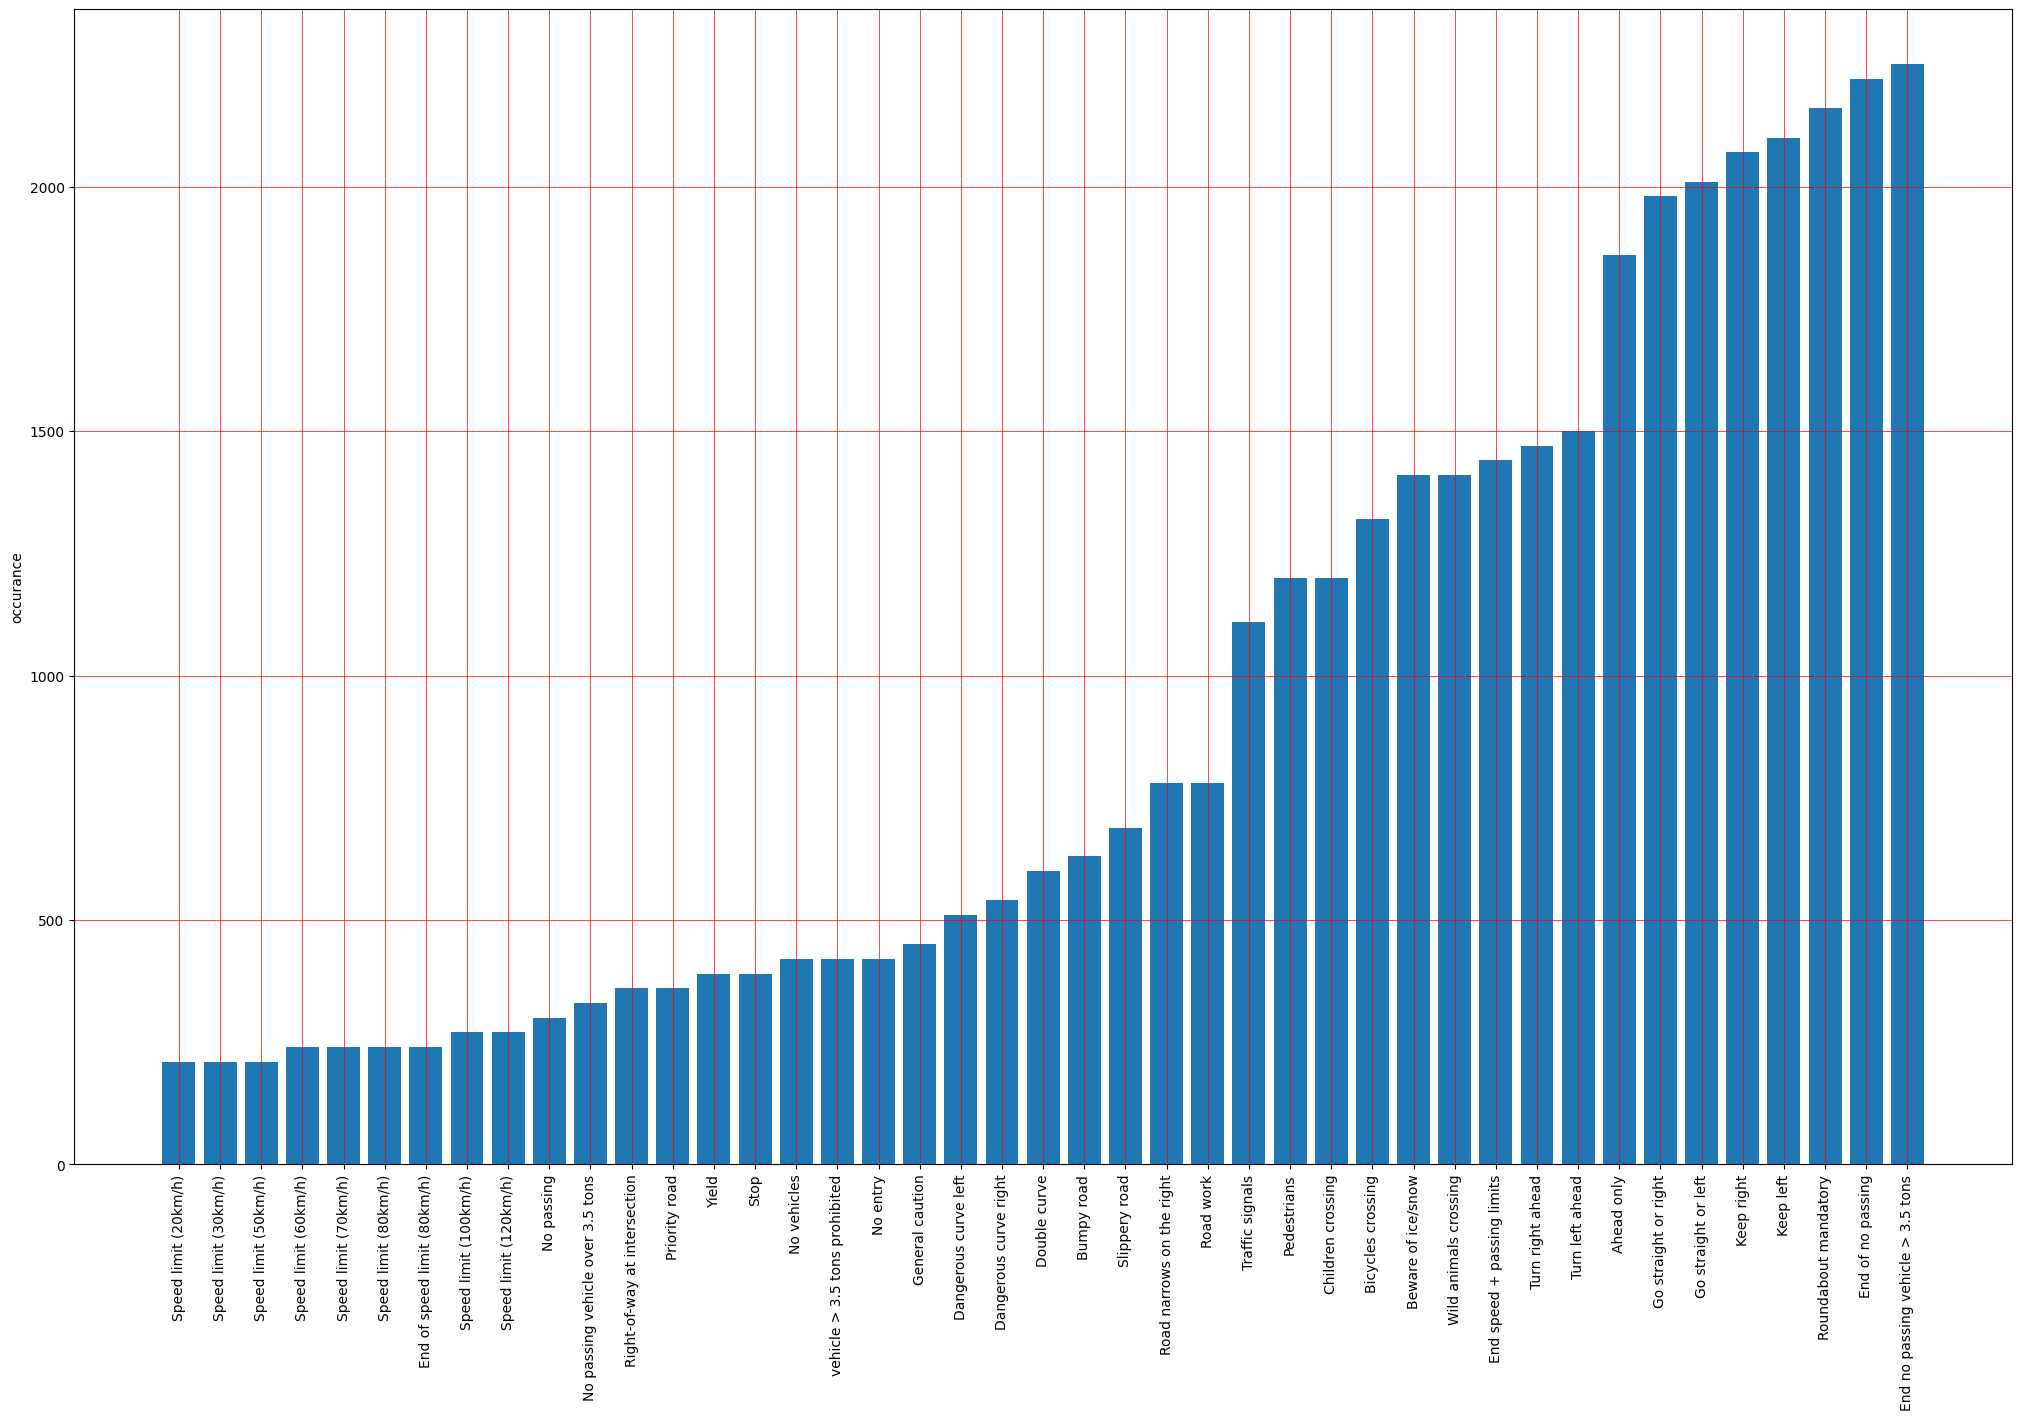

In [6]:
folders = os.listdir(train_path)

train_num = []
class_num = []

for folder in folders:
    occurance = os.listdir(train_path +"/"+ folder)
    train_num.append(len(occurance))
    class_num.append(int(folder))

## sorting the data into ascending order of occurance
train_num = np.sort(train_num)
class_num = np.sort(class_num)

##plotting the data
plt.figure(figsize=(25,15))
plt.grid(color="r",linewidth=0.5)
plt.bar(class_num,train_num)
plt.ylabel("occurance")
plt.xticks(class_num,labels[:,1],rotation='vertical') ##replacing the xticks to relevent class
plt.savefig("occurance.png")


Visualizing 25 random images from Test data

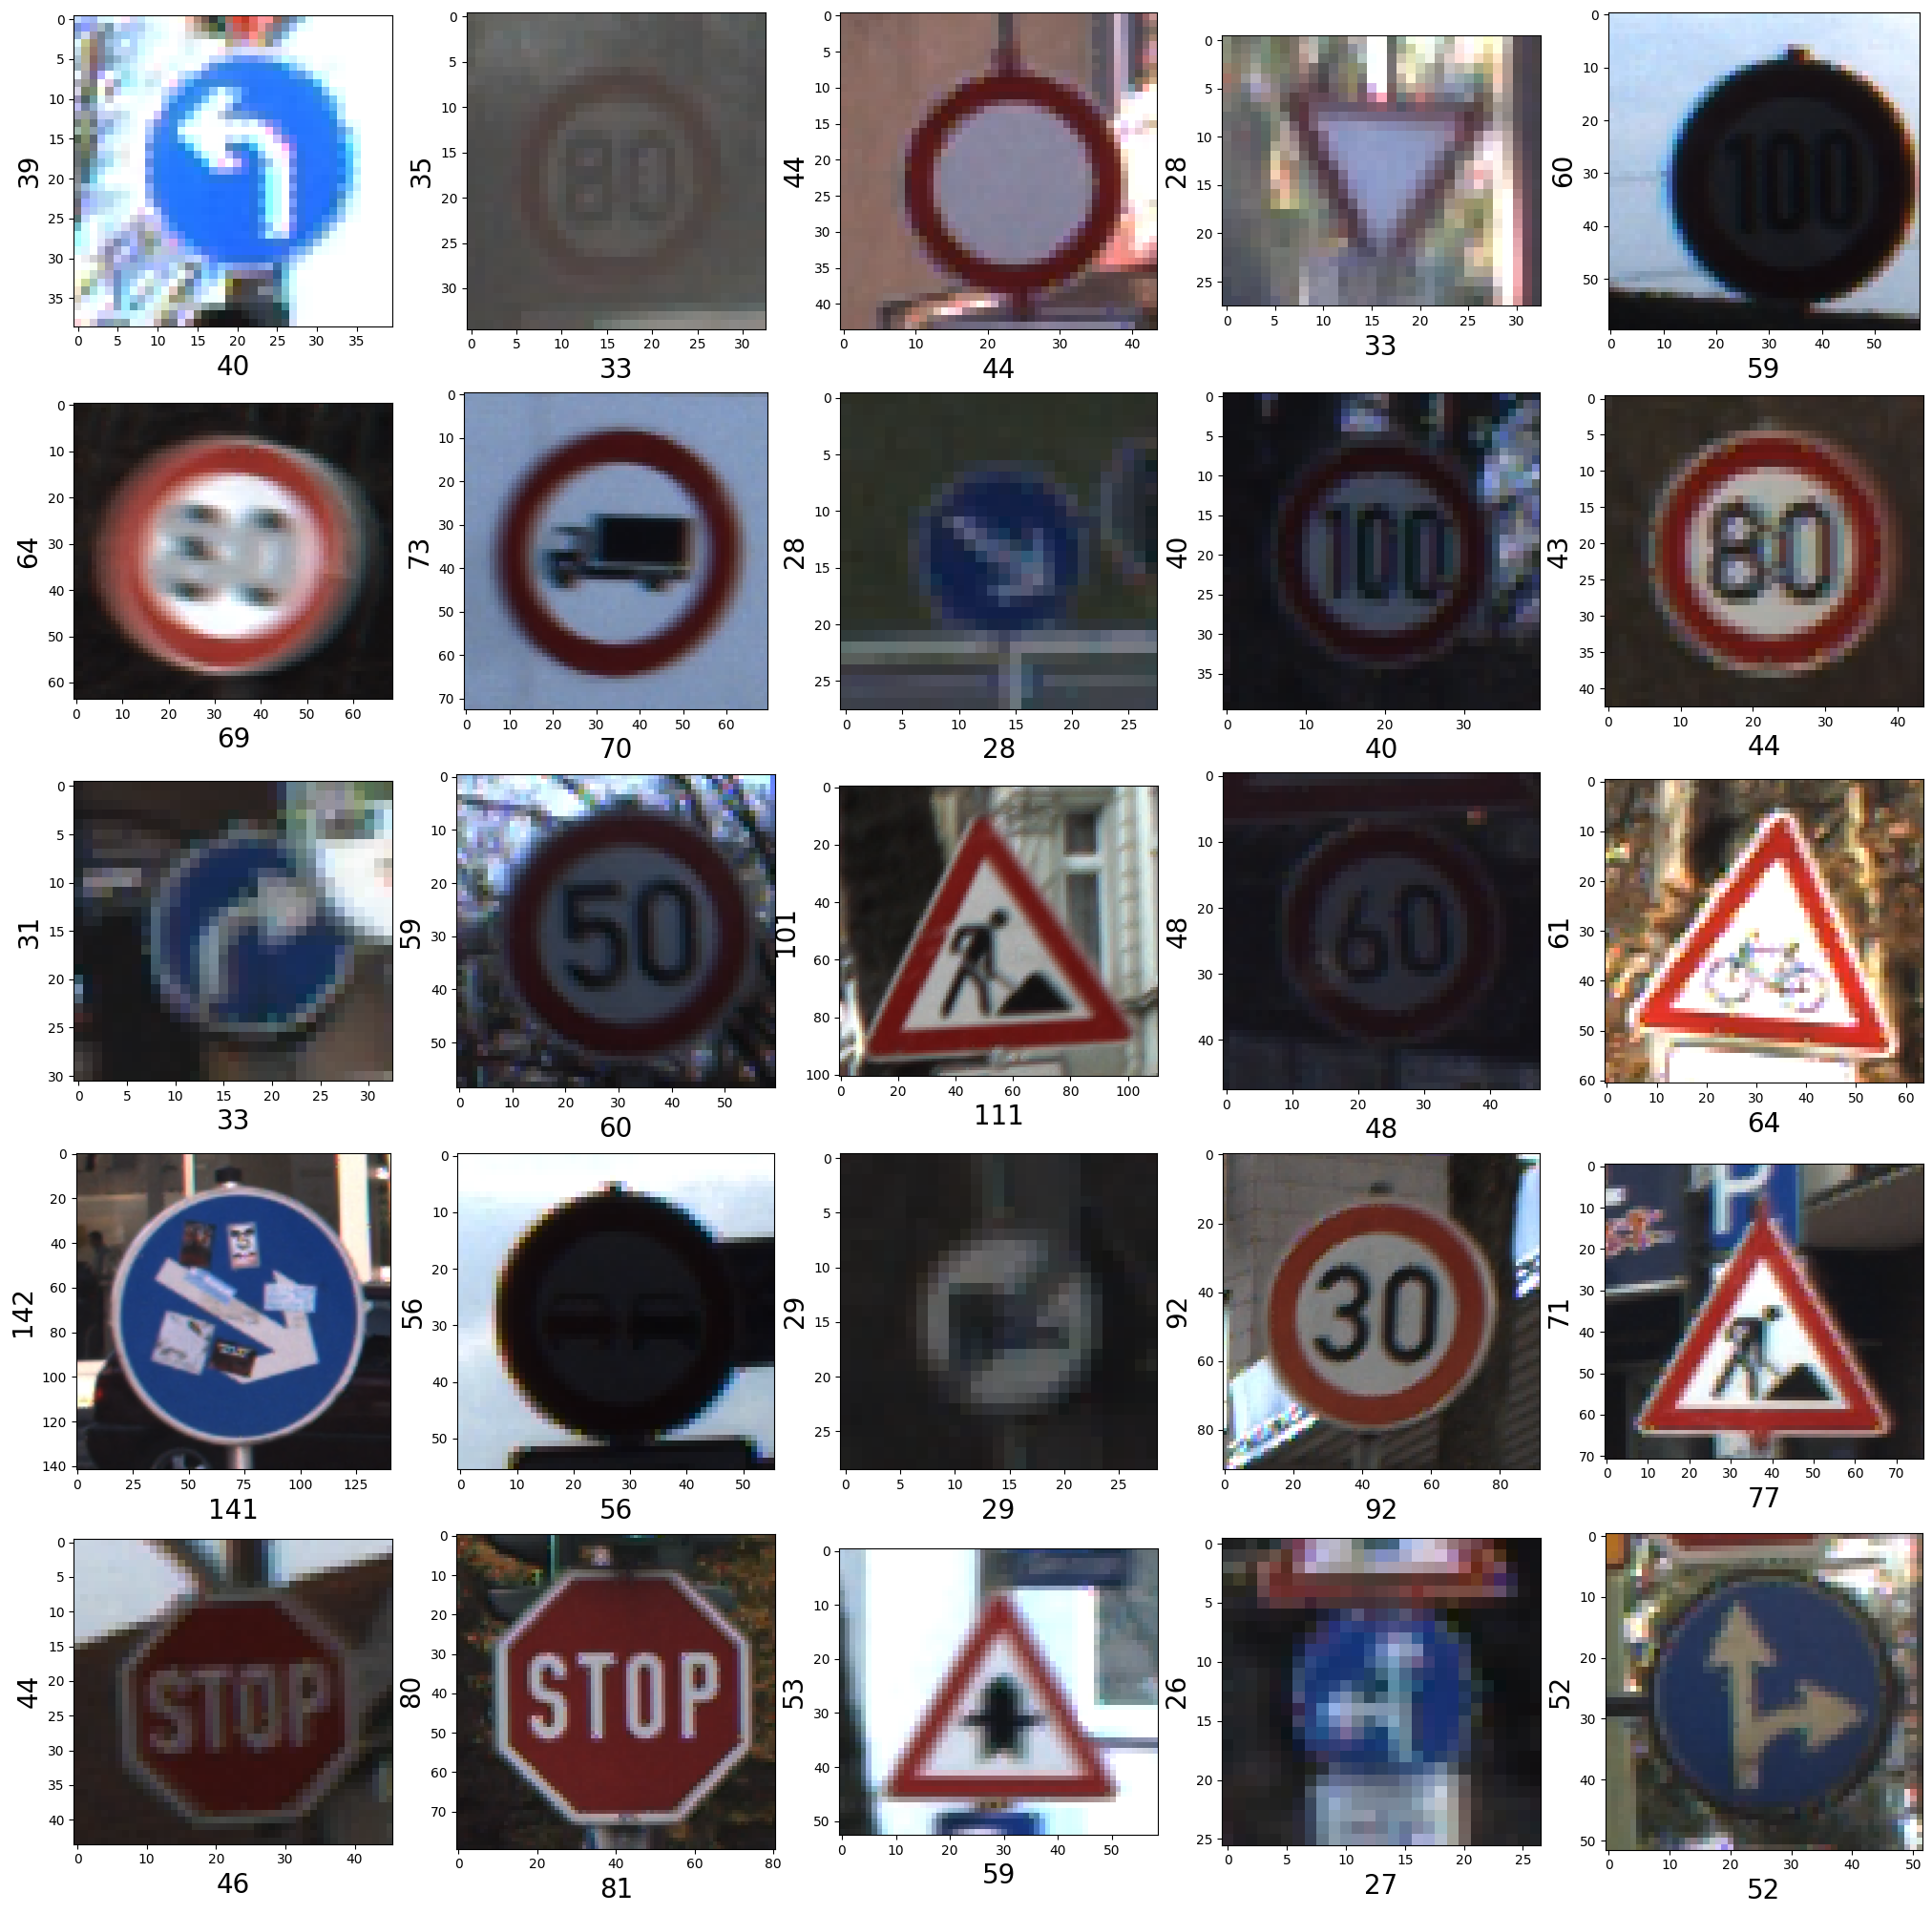

In [7]:
test = pd.read_csv(data + '/Test.csv')
imgs = test["Path"].values

plt.figure(figsize=(25,25))

for i in range(1,26):
    plt.subplot(5,5,i)
    rand_img = im.open(data +"/"+ np.random.choice(imgs))
    x,y = rand_img.size
    plt.imshow(rand_img)
    plt.xlabel(x, fontsize=20)
    plt.ylabel(y, fontsize=20)


Getting training data

In [8]:
image_data = []
image_labels = []

for i in range(N_Classes):
    path = data + '/Train/' + str(i)
    images = os.listdir(path)
    
    for img in images:
        image = im.open(path + '/' + img)
        resize_image = image.resize((IMG_HEIGHT, IMG_WIDTH))
        image_data.append(np.array(resize_image))
        image_labels.append(i)

image_labels = np.array(image_labels)
image_data = np.array(image_data)
image_labels.shape, image_data.shape

((39209,), (39209, 30, 30, 3))

Shuffling the data


In [9]:
shuffle_indexes = np.arange(image_data.shape[0])
np.random.shuffle(shuffle_indexes)
image_data = image_data[shuffle_indexes]
image_labels = image_labels[shuffle_indexes]

Splitting the data

In [10]:
X_train, X_val, y_train, y_val = train_test_split(image_data, image_labels, test_size=0.3, random_state=42, shuffle=True)

X_train = X_train/255 
X_val = X_val/255

print("X_train shape", X_train.shape)
print("X_valid shape", X_val.shape)
print("y_train shape", y_train.shape)
print("y_valid shape", y_val.shape)

X_train shape (27446, 30, 30, 3)
X_valid shape (11763, 30, 30, 3)
y_train shape (27446,)
y_valid shape (11763,)


One Hot Encoding

In [11]:
y_train = keras.utils.to_categorical(y_train, N_Classes)
y_val = keras.utils.to_categorical(y_val, N_Classes)

print(y_train.shape)
print(y_val.shape)

(27446, 43)
(11763, 43)


Creating the model

In [12]:
model = keras.models.Sequential([

    keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', input_shape=(IMG_HEIGHT,IMG_WIDTH,channels)),
    keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),
    
    keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),
    
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(rate=0.5),
    
    keras.layers.Dense(43, activation='softmax')
    
    ])

In [14]:
learning_rate = 0.001
epochs = 5

opt = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate, decay=learning_rate / (epochs * 0.5))
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

Training the model

In [15]:
aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest")

history = model.fit(aug.flow(X_train, y_train, batch_size=32), epochs=epochs, validation_data=(X_val, y_val))

Epoch 1/5
  5/858 [..............................] - ETA: 34s - loss: 4.9861 - accuracy: 0.0437 

2023-11-22 12:40:00.947250: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 24920064 exceeds 10% of free system memory.
2023-11-22 12:40:00.947333: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 24920064 exceeds 10% of free system memory.
2023-11-22 12:40:00.988912: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 24920064 exceeds 10% of free system memory.
2023-11-22 12:40:00.989036: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 24920064 exceeds 10% of free system memory.
2023-11-22 12:40:01.028731: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 24920064 exceeds 10% of free system memory.


858/858 [==============================] - 45s 51ms/step - loss: 1.0692 - accuracy: 0.7115 - val_loss: 0.0866 - val_accuracy: 0.9779
Epoch 2/5
858/858 [==============================] - 48s 56ms/step - loss: 0.1725 - accuracy: 0.9480 - val_loss: 0.0443 - val_accuracy: 0.9863
Epoch 3/5
858/858 [==============================] - 38s 45ms/step - loss: 0.1053 - accuracy: 0.9691 - val_loss: 0.0363 - val_accuracy: 0.9879
Epoch 4/5
858/858 [==============================] - 35s 41ms/step - loss: 0.0929 - accuracy: 0.9727 - val_loss: 0.0381 - val_accuracy: 0.9886
Epoch 5/5
858/858 [==============================] - 34s 39ms/step - loss: 0.0743 - accuracy: 0.9766 - val_loss: 0.0343 - val_accuracy: 0.9913


Model Evaluation

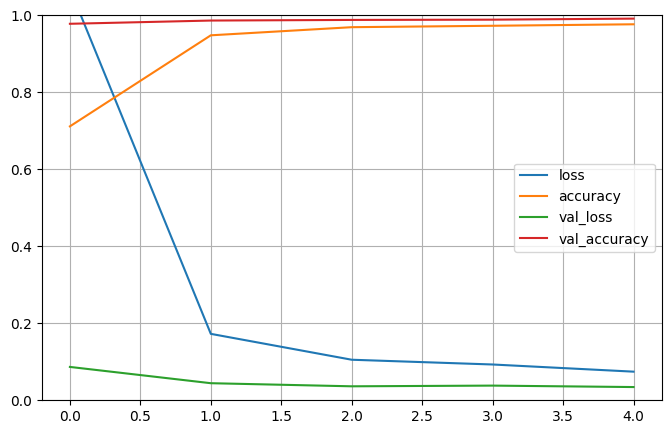

In [16]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

Predictions

In [17]:
test = pd.read_csv("Dataset/Test.csv")

labels = test["ClassId"].values
imgs = test["Path"].values

data1 =[]

for img in imgs:
    image = im.open(data + '/' + img)
    resize_image1 = image.resize((IMG_HEIGHT, IMG_WIDTH))
    data1.append(np.array(resize_image1))

X_test = np.array(data1)
X_test = X_test/255

pred = np.argmax (model.predict(X_test),axis=1)

print('test data accuracy:',accuracy_score(labels,pred)*100)

395/395 [==============================] - 3s 8ms/step
test data accuracy: 97.26049089469517


Classification report

In [18]:
print(classification_report(labels, pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        60
           1       0.99      1.00      1.00       720
           2       0.99      0.99      0.99       750
           3       0.99      0.99      0.99       450
           4       1.00      0.99      0.99       660
           5       0.99      0.99      0.99       630
           6       0.99      0.97      0.98       150
           7       1.00      0.99      0.99       450
           8       0.98      0.98      0.98       450
           9       0.98      1.00      0.99       480
          10       1.00      0.99      0.99       660
          11       0.94      0.94      0.94       420
          12       1.00      0.91      0.95       690
          13       1.00      0.99      0.99       720
          14       1.00      1.00      1.00       270
          15       0.96      0.98      0.97       210
          16       0.99      1.00      1.00       150
          17       1.00    

Prediction with Images

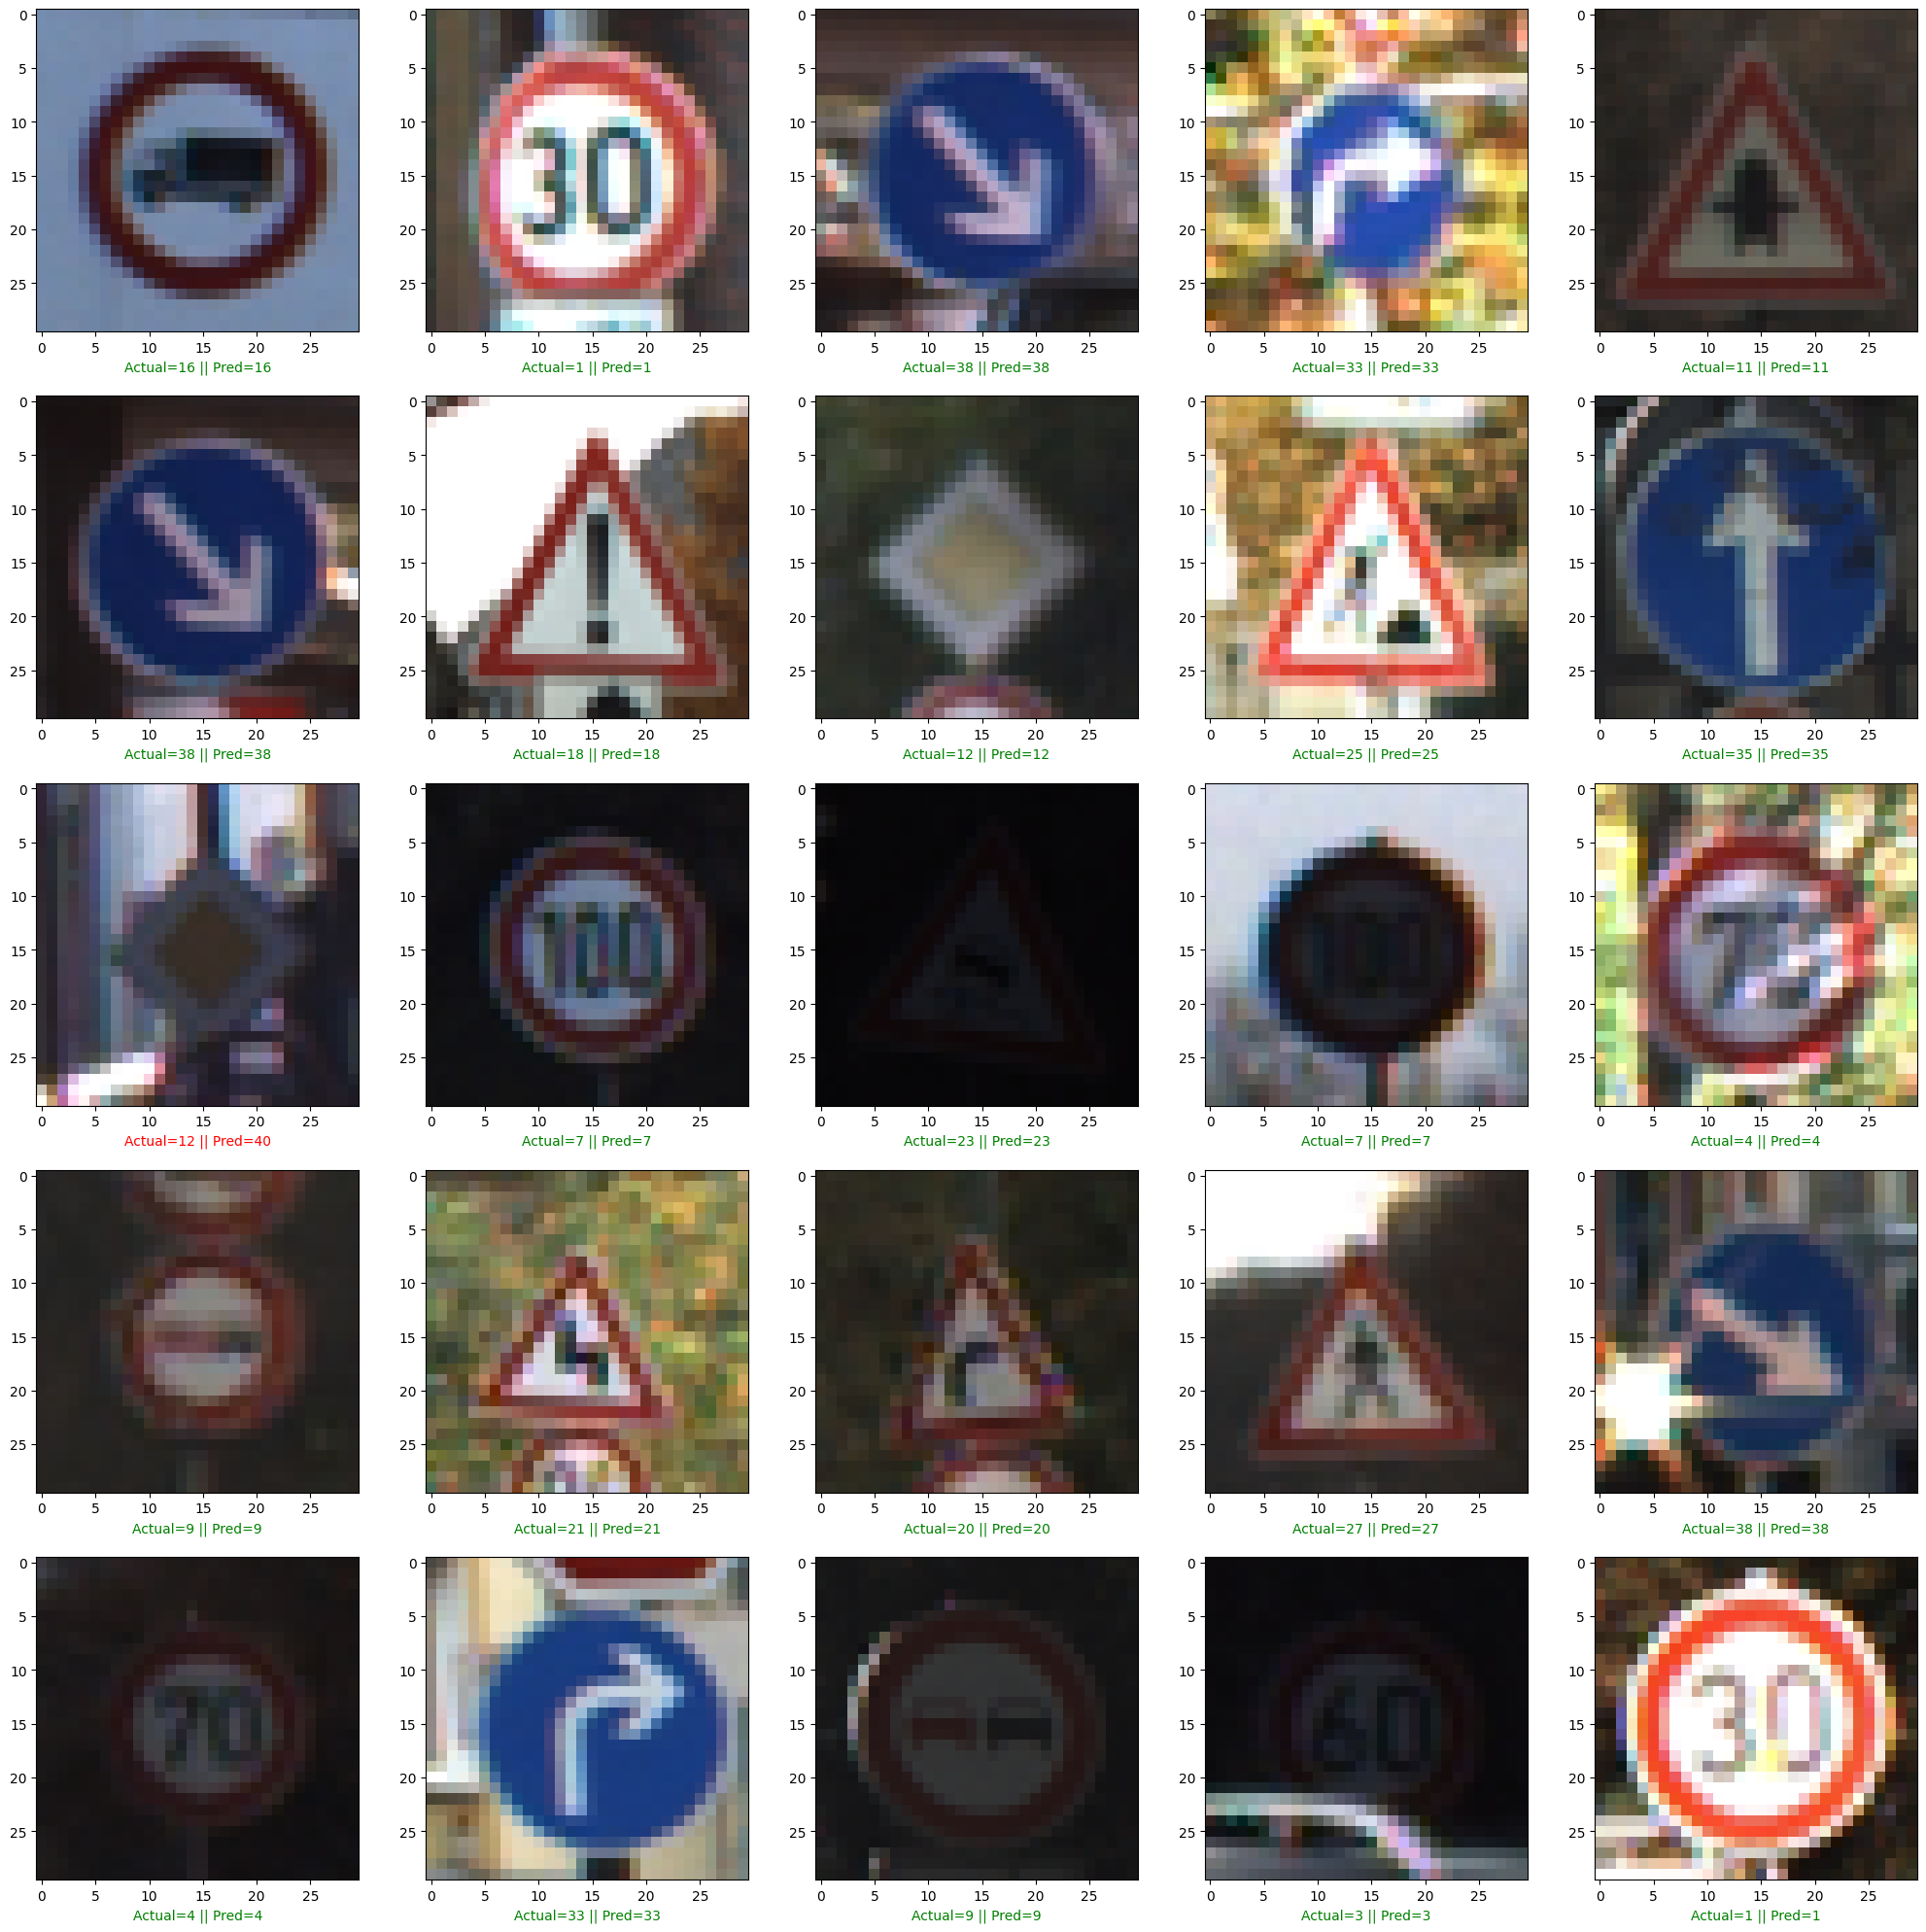

In [19]:
plt.figure(figsize = (25, 25))

start_index = 0
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.grid(False)
    prediction = pred[start_index + i]
    actual = labels[start_index + i]
    col = 'g'
    if prediction != actual:
        col = 'r'
    plt.xlabel('Actual={} || Pred={}'.format(actual, prediction), color = col)
    plt.imshow(X_test[start_index + i])
plt.show()

<h1 style="text-align: center;">Thank You For Your Attention !</h1>
